# Protected Probabilistic Classification

This notebook gives an implementation example of Protected classification for binary classification problems. 

Protected classification is decribed in more detail in:

 - Vovk, Vladimir, Ivan Petej, and Alex Gammerman. "Protected probabilistic classification." In Conformal and Probabilistic Prediction and Applications, pp. 297-299. PMLR, 2021. (arxiv version https://arxiv.org/pdf/2107.01726.pdf)

The Protected Classificaton algorithm can be applied in two ways:

- **batch mode** where we fit it to the training set only and when applied to the test set, the algorithm yields calibrated probability outputs in a similar way to Platt, Isotonic or Venn-Abers calibration
     
- **online mode**, where we assume examples in the test set arrive sequentially and the algorithm protects aagains changes in the underlying data distribution (withiut having to retrain the underlying algorithm)

In this example we focus on the former (**batch**) application.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibrationDisplay, calibration_curve
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from protected_classification import ProtectedClassification, cox_multiclass, gen_alpha

import warnings
warnings.filterwarnings('ignore')

## Basic usage

In [2]:
n_classes = 2
alphas = [list(np.zeros(n_classes))] + \
        [gen_alpha(ind, n_classes, 1) for ind in [n_classes - 1]] + \
        [gen_alpha(ind, n_classes, -1) for ind in [n_classes - 1]]

betas = [1, 0.5, 2]

### Create binary classification dataset

In [3]:
np.random.seed(seed=1)

X, y = make_classification(
    n_samples=1000, n_classes=2, n_informative=10, random_state=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Plot Cox Calibrators

In [4]:
calibs = [[cox_multiclass([i, 1-i], alp, bet) for i in np.linspace(0,1,11)] for alp in alphas for bet in betas]
calib_label = [[str(alp), str(bet)] for alp in alphas for bet in betas]

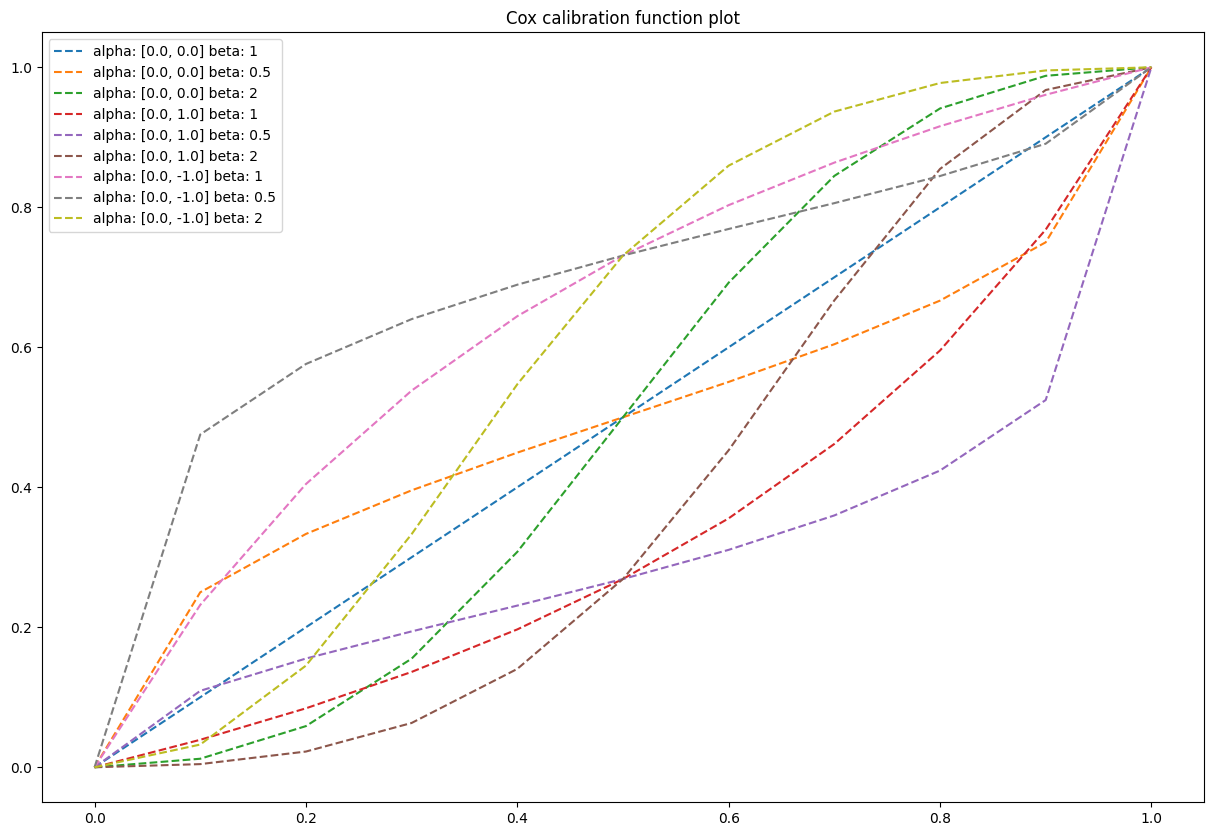

In [5]:
fig, ax = plt.subplots(figsize=(15,10))
for ind, calib in enumerate(calibs):
        ax.plot(np.linspace(0,1,11), np.array(calib)[:,0], '--', label = 'alpha: ' + calib_label[ind][0] + ' beta: ' + calib_label[ind][1])
plt.title("Cox calibration function plot")
plt.legend()
plt.show()

Given that we're dealing with a binary classifcation problem, we use a total of 9 Cox calibrators, which are shown above

## Applying Protected classification to an underlying scikit learn classifier

Here we use the Random Forest classifier as the underlying algorithm to which we apply Protected Calibration in the "batch mode", i.e. to the training set only

In [6]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
p_pred = clf.predict_proba(X_test)

pc = ProtectedClassification(estimator=clf)
pc.fit(X_train, y_train)
p_prime = pc.predict_proba(X_test)
y_prime = pc.predict(X_test)


metrics_list = []
metrics_list.append([
    'RF', 
    accuracy_score(y_test, y_pred), 
    brier_score_loss(y_test, p_pred[:,1]),
    log_loss(y_test, p_pred)]
    )

metrics_list.append([
    'RF - protected', 
    accuracy_score(y_test, y_prime), 
    brier_score_loss(y_test, p_prime[:,1]),
    log_loss(y_test, p_prime)]
    )

metrics_df = pd.DataFrame(metrics_list, columns = [
    'classifier', 'accuracy', 'brier_loss', 'log_loss'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)


,accuracy,brier_loss,log_loss
classifier,,,
RF,0.932,0.084,0.309
RF - protected,0.932,0.061,0.223


Protected classification improve log losses in this example

## Comparison with Platt and Isotonic calibration

In [7]:
clf  = RandomForestClassifier()
clf_isotonic = CalibratedClassifierCV(estimator=clf, cv=2, method='isotonic')
clf_sigmoid = CalibratedClassifierCV(estimator=clf, cv=2, method='sigmoid')
clf_protected =  ProtectedClassification(estimator=clf)


clf_list = [
    (clf, "Random Forest"),
    (clf_isotonic, "Random Forest- Isotonic"),
    (clf_sigmoid, "Random Forest- Platt"),
    (clf_protected, "Random Forest- Protected"),
]

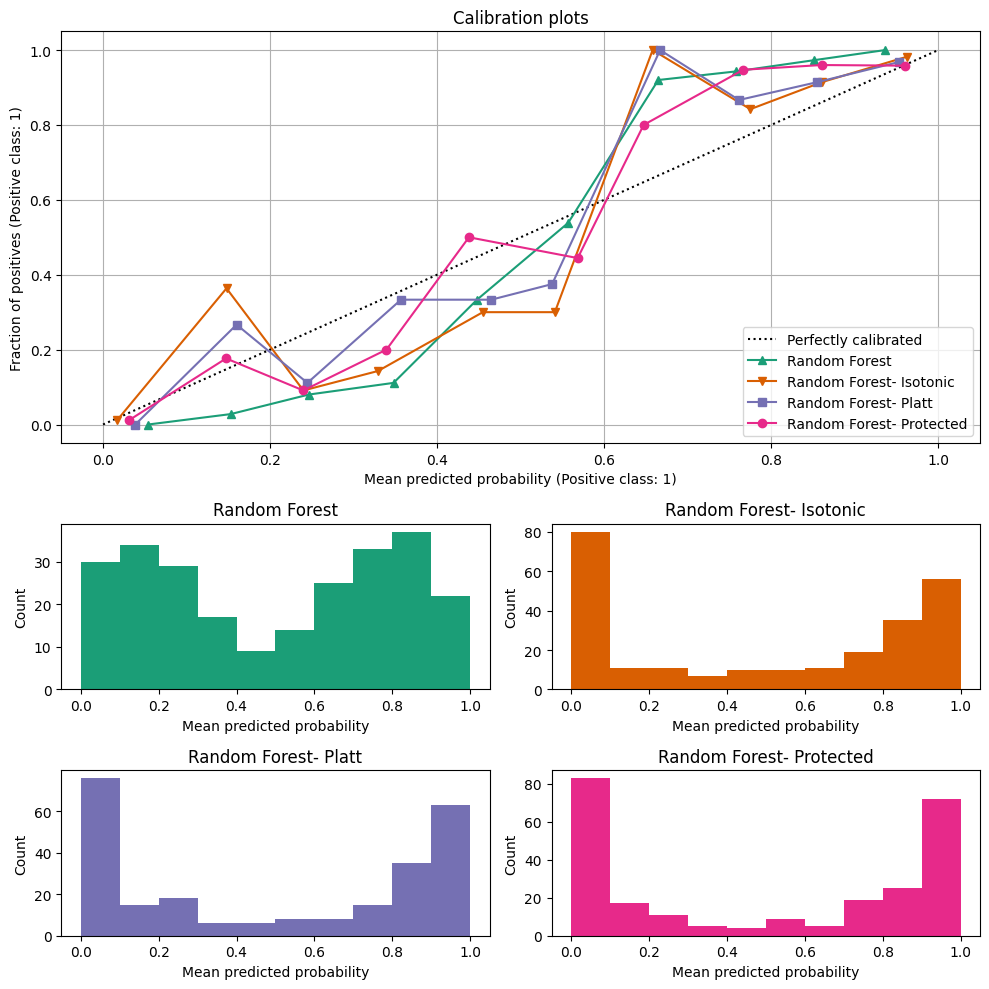

In [8]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

metrics_list = []

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)[:,1]
    l_loss = log_loss(y_test, y_prob)
    brier_loss = brier_score_loss(y_test, y_prob)
    if name != "Random Forest- Protected":
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metrics_list.append([name, acc, brier_loss, l_loss])
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = display
    else:
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metrics_list.append([name, acc, brier_loss, l_loss])
        display = CalibrationDisplay.from_predictions(
            y_test,
            y_prob,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
            marker=markers[i],
        )
        calibration_displays[name] = display
        

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [9]:
metrics_df = pd.DataFrame(metrics_list, columns = [
    'classifier', 'accuracy', 'brier_loss', 'log_loss'])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,accuracy,brier_loss,log_loss
classifier,,,
Random Forest,0.924,0.082,0.301
Random Forest- Isotonic,0.904,0.077,0.257
Random Forest- Platt,0.912,0.070,0.245
Random Forest- Protected,0.924,0.061,0.222


In this example Protected calibration achives a lower Brier and log loss and the same degree of accuracy as the underlying classifier